In [2]:
import pennylane as qml
from pennylane import numpy as np

# import numpy as np

from pennylane.optimize import NesterovMomentumOptimizer

dev = qml.device("default.qubit", wires = 2)

#  convert angle from the array x
def get_angles(x):
    beta0 = 2*np.arcsin( np.sqrt(x[1]**2) / np.sqrt(x[0]**2 +x[1]**2 + 1e-12) )
    beta1 = 2*np.arcsin( np.sqrt(x[3]**2) / np.sqrt(x[2]**2 +x[3]**2 + 1e-12) )
    beta2 = 2*np.arcsin( np.sqrt(x[2]**2 + x[3]**2) / np.sqrt(x[0]**2 +x[1]**2 + x[2]**2) )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


#  Rotate and CNOT(=entanglement)
def stateprep(a):
    qml.RY(a[0], wires = 0)
    qml.CNOT(wires = [0, 1])

    qml.RY(a[1], wires = 1)
    qml.CNOT(wires = [0, 1])

    qml.RY(a[2], wires = 1)

    qml.PauliX(wires = 0)
    
    qml.CNOT(wires = [0, 1])
    qml.RY(a[3], wires = 1)
    qml.CNOT(wires = [0, 1])
    qml.RY(a[4], wires = 1)
    qml.PauliX(wires = 0)

convert array_data to angle 

In [3]:
x = np.array([0.538, 0.795, 0.278, 0.0], requires_grad = False)
ang = get_angles(x)

@qml.qnode(dev, interface = "autograd")
def test(angles):

    stateprep(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x          : ",x)
print("angles     : ",ang)
print("amp vector : ",np.real(dev.state))


x          :  [0.538 0.795 0.278 0.   ]
angles     :  [ 0.56378405 -0.          0.         -0.97585942  0.97585942]
amp vector :  [ 5.38335757e-01  7.95496147e-01  2.78173495e-01 -1.38777878e-17]


x          :  [0.538 0.795 0.278 0.   ]
angles     :  [ 0.56378405 -0.          0.         -0.97585942  0.97585942]  => from get_angles
amp vector :  [0.5604565  0.82818386 0.         0.        ] => np.real(dev.state): returns the real part of the state vector of a quantum device.

In [4]:
def layer(W):
    qml.rot(W[0, 0], W[0, 1], W[0, 2], wires = 0)
    qml.rot(W[1, 0], W[1, 1], W[1, 2], wires = 1)
    qml.CNOT(wires = [0, 1])


@qml.qnode(dev, interface = "autograd")
def circuit(weights, angles):
    stateprep(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias 

def square_loss(labels, predictions):
    loss = 0

    # for variables in zip(x, y) => x, y data를 variables에 mapping 해준다. 
    for l,p in zip(labels, predictions):
        loss = loss + (l-p)**2

    # len: return number of items
    loss = loss / len(labels)
    return loss

def cost(weights, bias, features, labels):
    predicitons = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predicitons)

Variational classifier mdoel 

layer(W):
=> do rotation of the data and CNOT(=entanglement)

def circuit(weights, angles):
=> define quantum circuit.
1) stateprep for input variables
2) layer(W)
3) get expectation value of the pauli_z


def cost(weights, bias, features, labels)
=> calculate square loss for the predicitons
: (1/N) * (y^-y)^2

In [5]:
data = np.loadtxt("/home/iridescent923/home/Pennylane_tutorial/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (origianl) :", X[0])

padding = 0.3 * np.ones((len(X), 1)) 
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded) :", X_pad[0])

#  norm 이해 ㄴㄴ => np.sum
normalization = np.sqrt(np.sum(X_pad ** 2, -1)) 
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])
#  .T => transpose

features = np.array( [get_angles(x) for x in X_norm], requires_grad = False)
print("First features sample  : ", features[0])

Y = data[:, -1]


First X sample (origianl) : [0.4  0.75]
First X sample (padded) : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample  :  [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


np.ones((len(X), 1)) => creates array filled with '1'
=> (row, col)
out:
[1]
[1]
...
[1]

** what is np.c_ ??

- example code)

X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]

import numpy as np

X = np.array([1, 2, 3, 4])
Y = np.array([5, 6, 7, 8])

Z = np.c_[X, Y]

print(Z)

out: 

[[1 5]
 [2 6]
 [3 7]
 [4 8]]

X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
=> 

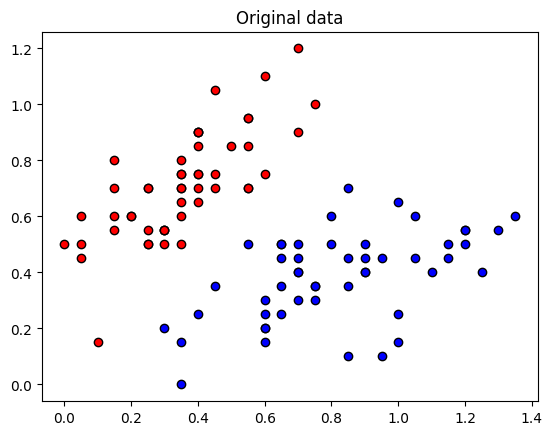

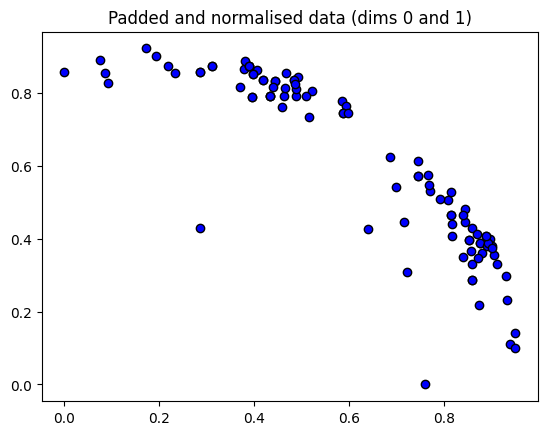

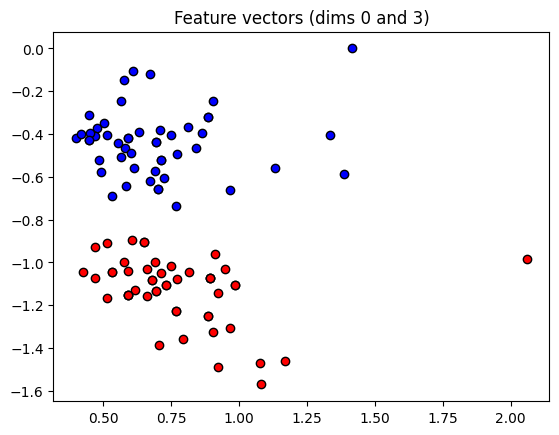

In [6]:
import matplotlib.pyplot as plt

# print(Y[:])

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c = "b", marker = "o", edgecolors = "k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c = 'b', marker = "o", edgecolors= "k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c = 'b', marker = "o", edgecolors= "k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

X[:, 0][Y == 1], X[:, 1][Y == 1]

print(X[:, 0][Y == 1])
=> X의 0_col data중에 Y==1이랑 matching되는 data만 출력

print(X)
=> out:
[[0.4  0.75]
 [0.3  0.5 ]
 [0.2  0.6 ]
 [0.15 0.55]
 [0.35 0.8 ]
 [0.55 0.95]
 [0.15 0.7 ]
 [0.35 0.7 ]
 [0.05 0.45]
 [0.3  0.55]
 [0.55 0.85]
 [0.25 0.7 ]
 [0.25 0.5 ]
 [0.   0.5 ]
 [0.75 1.  ]
 [0.7  1.2 ]
 [0.55 0.95]
 [0.4  0.75]
 [0.7  0.9 ]
 [0.4  0.9 ]
 [0.55 0.7 ]
 [0.4  0.85]
 [0.15 0.8 ]
 [0.4  0.65]
 [0.25 0.7 ]
...
 [0.7  0.45]
 [0.95 0.45]
 [0.4  0.25]
 [0.7  0.4 ]]

 and for Y[:]

 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]



plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c = "b", marker = "o", edgecolors = "k")
=> X's 0_th col data that matches with the label == 1 on x axis
and label == 0 on y axis


In [7]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [8]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3 , requires_grad = True)
bias_init = np.array(0.0, requires_grad = True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

weights = weights_init
bias = bias_init

for i in range(60):

    batch_index = np.random.randint(0, num_train, (batch_size,))